# Reproducing Figure 5

In [1]:
###################
# Import packages #
###################

import matplotlib.pylab as plt
import sys
import h5py
sys.path.append('../code/')
from makeCorner import *
import h5py

In [2]:
##############################
# Things related to plotting #
##############################

import matplotlib.pylab as plt
plt.rcParams.update({'font.size': 20})
plt.rcParams["font.family"]="Times New Roman"
rc_fonts = {
"text.usetex": True,
}
plt.rcParams.update(rc_fonts)
plt.rcParams["figure.figsize"] = (8,6) 

import seaborn as sns
my_palette = sns.color_palette("colorblind")

## Load in O3 results for comparison

In [3]:
hdata_O3 = h5py.File("../data/O3_CBC_GWB_MD.hdf","r")

Some of the runs were performed with a larger prior on the minimum time-delay parameter $t_d^{\rm min}$. To be consistent across all runs, we reject samples with a minimum time delay below $10^{-3}$. This corresponds to the minimum value displayed in the paper as well.

In [4]:
mask_td_min_CBC_GWB_MD_O3 = np.log10(hdata_O3['posterior/td_min'][()])>=-3

In [5]:
toPlot_O3 = {
    "kappa":{"data":hdata_O3['posterior/kappa'][()][mask_td_min_CBC_GWB_MD_O3],"plot_bounds":(-7,1),"label":r"$\kappa$"},
    "logZmax":{"data":np.log10(hdata_O3['posterior/Zmax'][()][mask_td_min_CBC_GWB_MD_O3]),"plot_bounds":(-4,0.1),"label":r"$\log \left(Z^{\rm max}/Z_\odot\right)$"},
    "log_td_min":{"data":np.log10(hdata_O3['posterior/td_min'][()][mask_td_min_CBC_GWB_MD_O3]),"plot_bounds":(-3,0),"label":r"$\log \left(t_d^{\rm min}/{\rm Gyrs}\right)$"}
}

## Load in O5 results and plotting

In [6]:
data_CBC_GWB_detectable_O5 = h5py.File("../data/O5_CBC_GWB_detectable_MD.hdf","r")

Some of the runs were performed with a larger prior on the minimum time-delay parameter $t_d^{\rm min}$. To be consistent across all runs, we reject samples with a minimum time delay below $10^{-3}$. This corresponds to the minimum value displayed in the paper as well.

In [7]:
mask_td_min_CBC_GWB_detectable_O5 = np.log10(data_CBC_GWB_detectable_O5['posterior/td_min'][()])>=-3

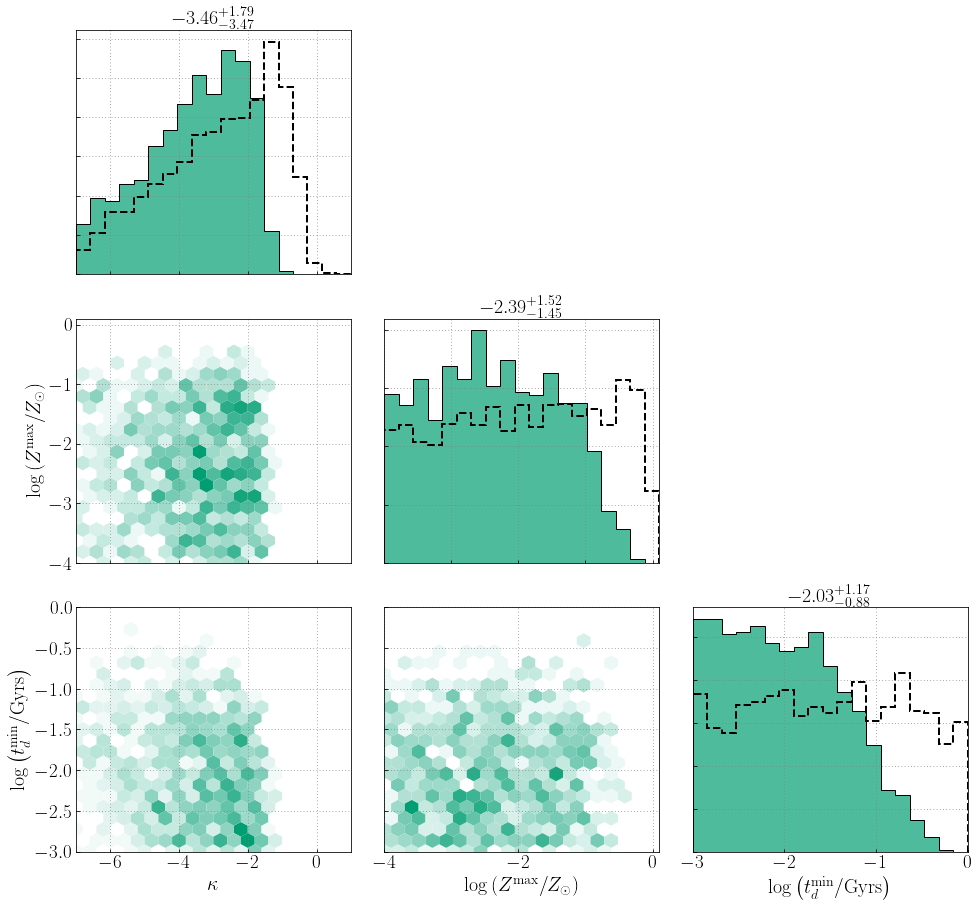

In [8]:
fig = plt.figure(figsize=(14,13))

toPlot_detectable_O5 = {
    "kappa":{"data":data_CBC_GWB_detectable_O5['posterior/kappa'][()][mask_td_min_CBC_GWB_detectable_O5],"plot_bounds":(-7,1),"label":r"$\kappa$"},
    "logZmax":{"data":np.log10(data_CBC_GWB_detectable_O5['posterior/Zmax'][()][mask_td_min_CBC_GWB_detectable_O5]),"plot_bounds":(-4,0.1),"label":r"$\log \left(Z^{\rm max}/Z_\odot\right)$"},
    "log_td_min":{"data":np.log10(data_CBC_GWB_detectable_O5['posterior/td_min'][()][mask_td_min_CBC_GWB_detectable_O5]),"plot_bounds":(-3,0),"label":r"$\log \left(t_d^{\rm min}/{\rm Gyrs}\right)$"}
}

plot_corner_plus_hist_contour(fig,toPlot_detectable_O5,toPlot_O3,color=my_palette[2],labelsize=22)
plt.tight_layout()
plt.savefig("PosteriorO5detectable.pdf",dpi=500,bbox_inches='tight')
plt.show()